In [58]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot as plt
from bertopic import BERTopic
from datetime import datetime

In [59]:
import umap
import seaborn as sns
import numpy as np
import pandas as pd

## Lectura del dataset "app_reviews"

In [60]:
review = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')
review = review.drop(['date','star'],axis=1)
#review = pd.read_csv('C:/Users/USUARIO/Documents/Universidad/4A. Inteligencia Artificial/Dataset/app_reviews.csv')
review

,package_name,review
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...
...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...
288061,com.termux.api,I like this app . Its is very helpful for use....
288062,com.termux.api,Finally Brings back the Unix command line to A...
288063,com.termux.api,The API feature is great just need loads more...


### Se extrae en un corpus todos los reviews o criticas de usuario

In [61]:
def extract_corpus(dataset):
    print(datetime.today(), "extrayendo oraciones...")
    lista = []  
    for i in range(len(dataset['package_name'].unique())):#iterar entre los package_name unicos
        dataset_temp = dataset.loc[dataset['package_name'] == dataset['package_name'].unique()[i]]
        lista.append({'package_name':dataset['package_name'].unique()[i], 'size': len(dataset_temp)})#otener un package_name y el número de oraciones

    lista = sorted(lista, key=lambda x: x['size'], reverse=True)#se ordena para saber que package_name tiene el mayor n° de oraciones
    dataframe = dataset[dataset['package_name'] == lista[1]['package_name']]#el mayor será el elemnto que ocupa la posicion 0
    corpus = list(dataframe['review'])#extraemos un corpus
    
    #corpus = clean_corpus(corpus)

    return corpus

### Convertir datos en un Dataframe a un manejo más ágil

In [62]:
def convert_corpus_to_dataFrame(corpus):
    print(datetime.today(), "Convirtiendo las oraciones extraidas a un dataframe...")
    corpus_ds = {
        'Sentences' : corpus
    }

    dataset_new = pd.DataFrame(corpus_ds)
    return dataset_new

In [63]:
def convert_embbedings_to_dataFrame(embeddings):
    print(datetime.today(), "Convirtiendo las incrustaciones a un dataframe...")
    array = []
    for i in embeddings:
        array.append([i])

    dataset_new = pd.DataFrame(array, columns=['Embeddings'])
    return dataset_new

### Se crea una función que nos permita incrustar las oraciones, para esto usamos un modelo pre-entrenado de SBERT

In [64]:
def neural_embeddings(dataset):
    model_embedder = SentenceTransformer('all-MiniLM-L6-v2')#modelo pre-entrenado
    corpus = extract_corpus(dataset)#extraemos un corpus del dataset 
    print(datetime.today(), "Incrustando las oraciones...")
    embeddings = model_embedder.encode(corpus, 
                                        convert_to_tensor=False, 
                                        show_progress_bar=True) #generamos las incrustaciones 

    embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True) #normalizamos

    return embeddings, corpus

In [65]:
def neural_embeddings_queries(queries):
    model_embedder = SentenceTransformer('all-MiniLM-L6-v2')#modelo pre-entrenado

    embeddings_queries = model_embedder.encode(queries, 
                                        convert_to_tensor=False) #generamos las incrustaciones 

    embeddings_queries = embeddings_queries /  np.linalg.norm(embeddings_queries, axis=0, keepdims=True) #normalizamos

    return embeddings_queries

### Para obtener el "mejor" cluster aplicamos el método de la silueta

In [66]:
#en esta funcion hace la tarea de obtener el mejor k con agglomerative clustering
def silhoutte(dataset, attempts):
    embeddings, corpus = neural_embeddings(dataset)
    print(datetime.today(), "Calculando el mejor k...")
    scores_silhouette = [] #guardaremos todos los resultados del método de la silueta para devolver el mayor

    for k in range(2,attempts+1):
        agglomerative_clusterering = AgglomerativeClustering(n_clusters=k, 
                                                            affinity="cosine" , 
                                                            linkage="complete").fit(embeddings)
                                                            
        cluster_labels = agglomerative_clusterering.labels_

        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        scores_silhouette.append(silhouette_avg)

    max_score = max(scores_silhouette)
    max_index = scores_silhouette.index(max_score)
    n_clusters = max_index + 2

    return n_clusters, embeddings, corpus

### Al tener el "mejor" número de clusters, se procede a segmentar las oraciones

In [67]:
def topics_segmentation(dataset_review, attempts):
    n_clusters, embeddings, corpus = silhoutte(dataset_review, attempts) # se le pasa el mejor K

    agglomerative_clusterering = AgglomerativeClustering(n_clusters=n_clusters, 
                                                        affinity="cosine", 
                                                        linkage="complete").fit(embeddings)
                                                        
    cluster_labels = agglomerative_clusterering.labels_ #obtengo las etiquetas respectivas a las oraciones

    model_topics = BERTopic(nr_topics = n_clusters, language='english') # entreno para sacar K temas 
    topics, prob = model_topics.fit_transform(corpus)

    label_topics = model_topics.generate_topic_labels(nr_words=8, topic_prefix=False) # temas
    
    #hierarchical_topics = model_topics.hierarchical_topics(corpus,topics)

    #print(hierarchical_topics)
    #print(label_topics)

    label_topics.pop(0) #elimino el grupo de temas atípicos

    return cluster_labels, label_topics, embeddings, corpus

### A cada oración le asignamos el cluster al que pertenece

In [69]:
def clustering(dataset_review, attempts):
    cluster_labels, label_topics, embeddings, corpus = topics_segmentation(dataset_review, attempts)
    print(datetime.today(), "Asignando un cluster a cada oración...")
    corpus_dataframe = convert_corpus_to_dataFrame(corpus) #de set de oraciones se convierte en un DF para asignarle su número de cluster
    corpus_dataframe['cluster'] = cluster_labels #se le asigna a cada oración un cluster

    return embeddings, label_topics, corpus_dataframe

### Búsqueda semántica para encontrar el tema de cada cluster

In [ ]:
def semantic_search(dataset_review, attemps):
    embeddings, label_topics, corpus_dataframe = clustering(dataset_review, attemps) #tomo embeddings para no volver a hacer el mismo trabajo 2 veces
    dataframe_embeddings = convert_embbedings_to_dataFrame(embeddings) #convierto a cada lista de embeddings en un DF para evaluar con cada tema
    dataframe_embeddings['cluster'] = corpus_dataframe['cluster'] # le asigno los clusters
    sort_embeddings =  dataframe_embeddings.sort_values(by=['cluster']) 
    sort_embeddings = sort_embeddings.reset_index(drop=True)
    nr_clusters = sort_embeddings['cluster'].unique() # extrae las un representante de cada cluster

    first_sentences = [] #se almacenara cada primera oracion incrustada de cada cluster para asignarle un topic
    j = 0
    i = 0
    while i < len(sort_embeddings):               
        if(j < len(nr_clusters) and sort_embeddings['cluster'][i] == nr_clusters[j]):
            first_sentences.append(sort_embeddings['Embeddings'][i]) #almacena
            j+=1
        i+=1

    queries = label_topics #queries seran los temas
    topics = [] 
    in_clusters = [] #se almacena los temas y los clusters, para que tengan un mismo índice en común
    print(datetime.today(), "Incrustando los temas...")
    for topic in queries:

        embeddings_queries = neural_embeddings_queries(topic) #incrusta los temas 
        cos_scores = util.cos_sim(embeddings_queries, first_sentences)[0] #se saca la similaridad de cada tema con respecto a las demas oraciones

        cos_scores_numpy = cos_scores.numpy() #se convierte a tensor a numpu
        cos_scores_list = cos_scores_numpy.tolist() #se convierte de numpy a list
        max_coincidence = max(cos_scores_list)
        cluster = cos_scores_list.index(max_coincidence)

        if(len(topics) == 0): 
            topics.append(topic)
            in_clusters.append(cluster)

        elif(topic not in topics and cluster not in in_clusters): #para que no repite un tema con un cluster y viceversa
            topics.append(topic)
            in_clusters.append(cluster)
    tupla = [] ##tamaño k -> k es el tamaño de cluster
    for i in range(len(topics)):
        tupla.append({'Topics': topics[i] , 'Cluster': in_clusters[i]}) #empareja    
    print(tupla)

    return embeddings, tupla, corpus_dataframe
        

### Para dar visualización de estas oraciones en un plano euclidiano, aplicamos una técnica de reducción de dimensiones 

In [71]:
def dimension_reduction(embeddings):
    print(datetime.today(), "Reduciendo la dimensión de las incrustaciones...")
    scaler = umap.UMAP(n_components=2).fit_transform(embeddings)
    dimension_2d = pd.DataFrame(scaler, columns=['x', 'y'])
    return dimension_2d

### Mostraremos un gráfico de la segmentación de oraciones y un DataFrame de las oraciones con su respectivo cluster 

In [72]:
def show_graphics_and_themes(dataset_review, attemps):
    embeddings, reporte_tuplas, corpus_dataframe = semantic_search(dataset_review, attemps)
    review_2d = dimension_reduction(embeddings) #se reduce a dos dimensiones las incrustaciones para poder plotear
    review_2d['labels'] = corpus_dataframe['cluster']
    
    reporte_tuplas = pd.DataFrame(reporte_tuplas, columns=['Topics','Cluster'])

    plt.figure(figsize=(15, 15))
    clustered = review_2d[review_2d.labels != -1]

    plt.scatter(review_2d.x, 
                review_2d.y, 
                c=clustered.labels, 
                s=20,
                cmap='Spectral')

    plt.colorbar()
    plt.show()
    
    return corpus_dataframe, reporte_tuplas

2022-08-19 13:40:12.691190 extrayendo oraciones...
2022-08-19 13:40:54.259958 Incrustando las oraciones...


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

2022-08-19 13:42:31.333176 Calculando el mejor k...
2022-08-19 13:47:30.460771 Calculando los temas...
2022-08-19 13:49:21.062988 Asignando un cluster a cada oración...
2022-08-19 13:49:21.062988 Convirtiendo las oraciones extraidas a un dataframe...
2022-08-19 13:49:21.064984 Convirtiendo las incrustaciones a un dataframe...
2022-08-19 13:49:21.068973 Asignando un tema a cada cluster...
2022-08-19 13:49:21.114850 Incrustando los temas...
2022-08-19 13:49:31.312979 Incrustando los temas...
2022-08-19 13:49:40.476557 Incrustando los temas...
2022-08-19 13:49:48.843511 Incrustando los temas...
2022-08-19 13:49:57.321991 Incrustando los temas...
2022-08-19 13:50:06.014411 Incrustando los temas...
2022-08-19 13:50:14.897514 Incrustando los temas...
2022-08-19 13:50:24.028916 Incrustando los temas...
2022-08-19 13:50:32.545663 Incrustando los temas...
2022-08-19 13:50:41.445955 Incrustando los temas...
2022-08-19 13:50:50.323782 Incrustando los temas...
2022-08-19 13:50:59.051939 Incrustand

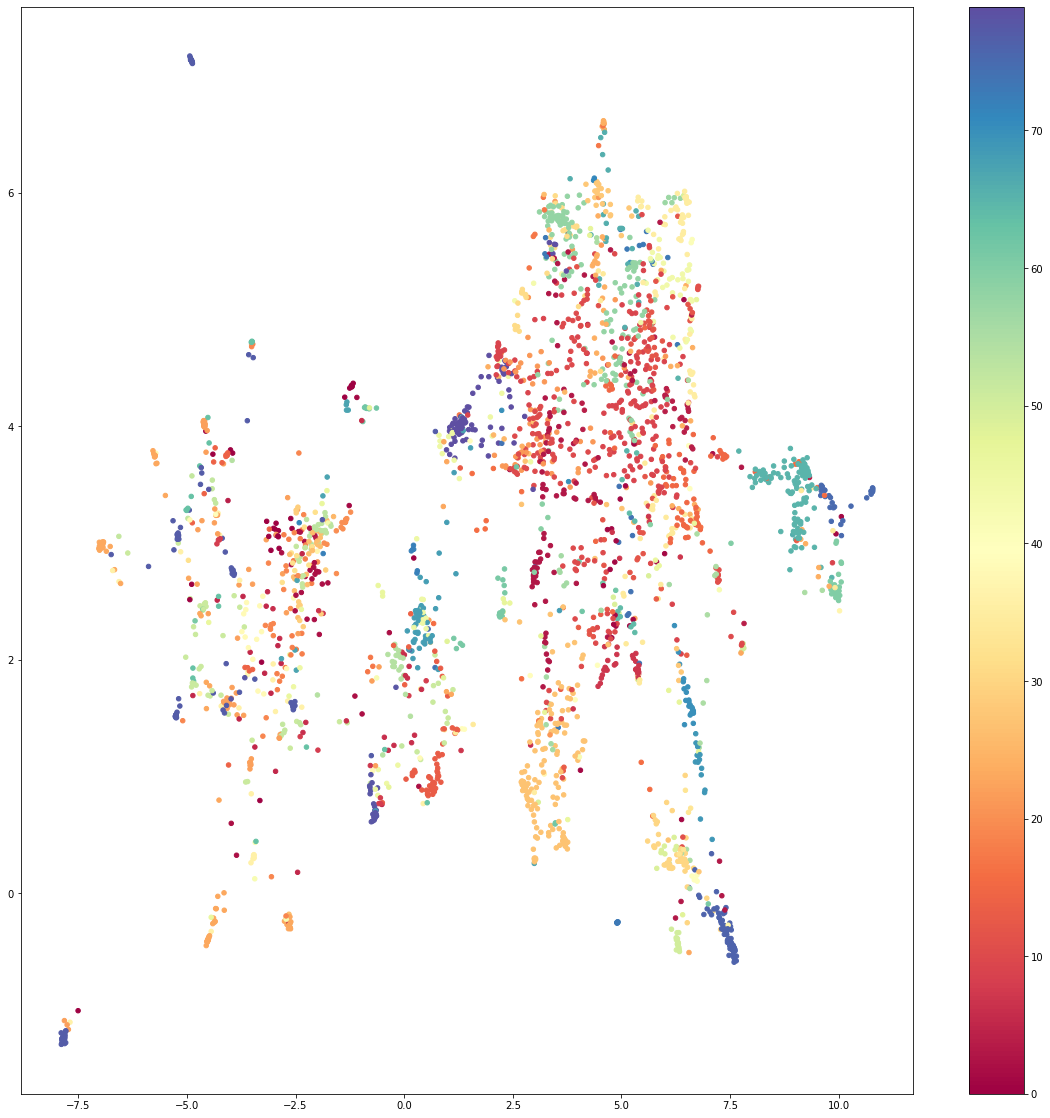

In [73]:
topics, reporte = show_graphics_and_themes(review, 100)

In [81]:
topics

,Sentences,cluster
0,Authentication Morris,31
1,I can't access my account We couldn't verify y...,9
2,This app works fine Later found the secret key...,15
3,very good love it,23
4,Powerful app Awesome app to safe my transaction,21
...,...,...
2971,I'm feeling very well,78
2972,Doesn't work can't add any accounts.,9
2973,Only one concern but not sure if it was the ap...,10
2974,Verygood,22


In [91]:
reporte

,Topics,Cluster
8,facebook_whatsapp_help_messenger_upgrading_asa...,1
40,verification_code_step_google_in_authenticator...,3
38,new_sd_transfer_move_phone_card_to_moving,4
26,good_app_liked_application_life_useful_idea_ch...,6
34,download_slow_bored_takes_hate_72_checking_stil,7
18,ok_lol_troubling_nooooo_hahaha_omg_okay_noting,8
31,security_secure_app_great_for_your_google_extra,10
11,copy_tap_clipboard_should_instead_button_code_...,11
21,works_perfectly_just_advertised_it_without_gre...,13
2,nice_softwer_shit_lovely_feel_like_though_getting,14
